<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/ochuman_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [OCHuman dataset](https://github.com/liruilong940607/OCHumanApi/tree/958aa2046ba4f5760fcc94cb458da8fe72cedf4f)

From the OCHuman repo:
> This dataset focus on heavily occluded human with comprehensive annotations including bounding-box, humans pose and instance mask. This dataset contains 13360 elaborately annotated human instances within 5081 images. With average 0.573 MaxIoU of each person, OCHuman is the most complex and challenging dataset related to human. Through this dataset, we want to emphasize occlusion as a challenging problem for researchers to study.



## Installing IceVision

In [11]:
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q
!pip install git+git://github.com/airctic/icedata.git -q

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

## Defining OCHuman parser

In [1]:
from icevision.all import *

_ = icedata.ochuman.load_data()

INFO     - 
    MANUALLY download AND unzip the dataset from https://cg.cs.tsinghua.edu.cn/dataset/form.html?dataset=ochuman. 
    You will need the path to the `ochuman.json` annotations file and the `images` directory.
     | icedata.datasets.ochuman.data:load_data:11


## Parse data

In [2]:
parser = icedata.ochuman.parser("../OCHuman/ochuman.json", "../OCHuman/images/images/")

train_records, valid_records = parser.parse(data_splitter=RandomSplitter([0.8, 0.2]),
                                            cache_filepath="../OCHuman/ochuman.pkl")

  0%|          | 0/5081 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:132


In [3]:
len(train_records), len(valid_records)

(4064, 1017)

In [11]:
train_records[0]

Record:
	- Image ID: 4306
	- Image size (width, height): (1000, 721)
	- Filepath: ../OCHuman/images/images/003909.jpg
	- BBoxes: [<BBox (xmin:820, ymin:49, xmax:998, ymax:713)>, <BBox (xmin:829, ymin:4, xmax:988, ymax:608)>]
	- KeyPoints: [<KeyPoints (11 visible keypoints)>, <KeyPoints (17 visible keypoints)>]
	- Labels: [1, 1]

## Datasets + augmentations

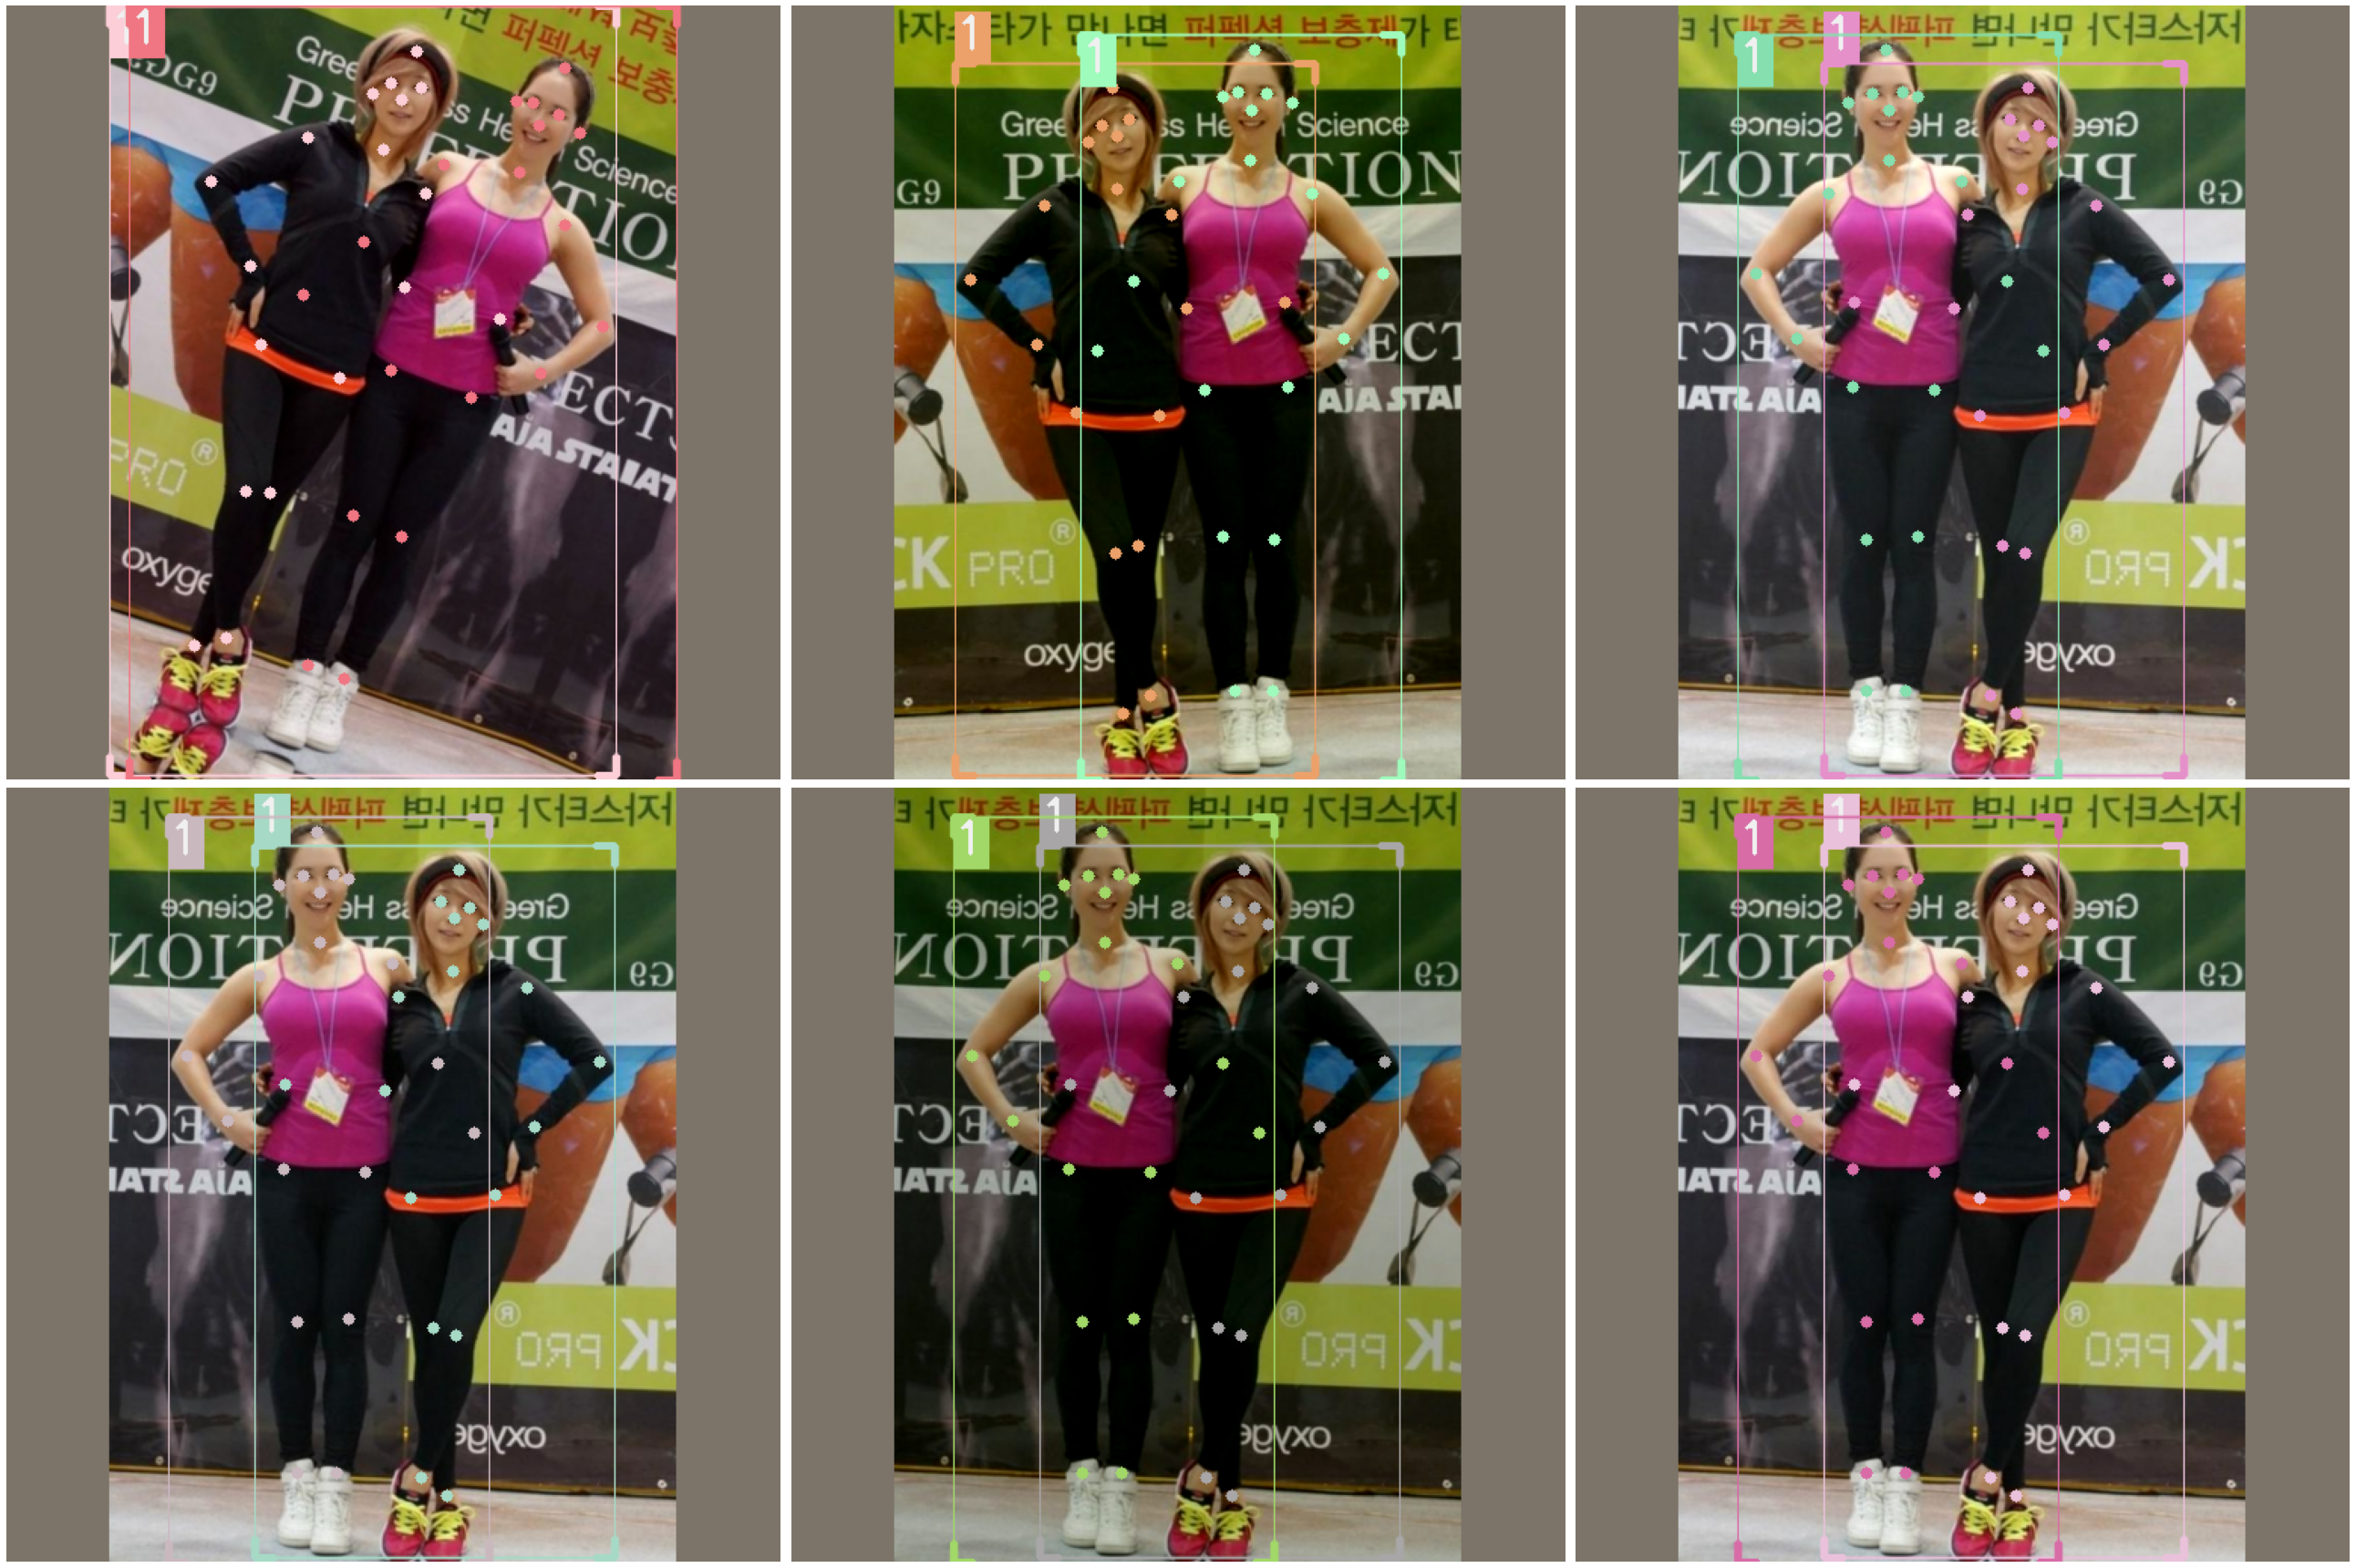

In [17]:
presize = 1024
size = 512

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

samples = [train_ds[1] for _ in range(6)]
show_samples(samples, ncols=3)

In [18]:
len(train_ds), len(valid_ds)

(4064, 1017)

## Dataloaders

In [19]:
train_dl = keypoint_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = keypoint_rcnn.valid_dl(train_ds, batch_size=16, num_workers=4, shuffle=False)

## Model

In [20]:
model = keypoint_rcnn.model(num_keypoints=19)

## Train a `fastai` learner

In [21]:
from fastai.callback.tracker import SaveModelCallback

In [22]:
learn = keypoint_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, cbs=[SaveModelCallback()])

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=0.0002290867705596611)

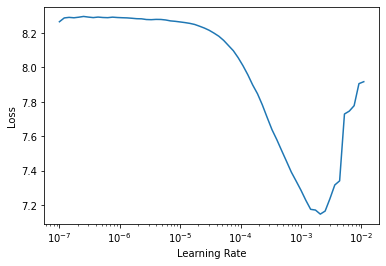

In [23]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, slice(2e-4), pct_start=0.99)

Better model found at epoch 0 with valid_loss value: 4.942918300628662.
Better model found at epoch 1 with valid_loss value: 4.636247158050537.
Better model found at epoch 2 with valid_loss value: 4.549318790435791.
Better model found at epoch 3 with valid_loss value: 4.479443073272705.
Better model found at epoch 4 with valid_loss value: 4.405727386474609.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

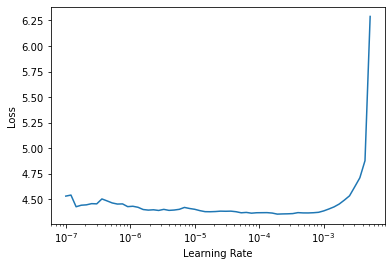

In [29]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.unfreeze()
base_lr = 3e-5
learn.fit_one_cycle(20, slice(base_lr/100, base_lr), pct_start=0.3, div=5.0)

Better model found at epoch 0 with valid_loss value: 4.280224800109863.
Better model found at epoch 1 with valid_loss value: 4.245229721069336.
Better model found at epoch 2 with valid_loss value: 4.205602645874023.
Better model found at epoch 3 with valid_loss value: 4.184842586517334.
Better model found at epoch 4 with valid_loss value: 4.1448798179626465.
Better model found at epoch 5 with valid_loss value: 4.128637790679932.
Better model found at epoch 6 with valid_loss value: 4.091643333435059.
Better model found at epoch 7 with valid_loss value: 4.076290607452393.
Better model found at epoch 8 with valid_loss value: 4.054412364959717.
Better model found at epoch 9 with valid_loss value: 4.02548360824585.
Better model found at epoch 10 with valid_loss value: 4.010230541229248.
Better model found at epoch 11 with valid_loss value: 3.9950363636016846.
Better model found at epoch 12 with valid_loss value: 3.981722831726074.
Better model found at epoch 13 with valid_loss value: 3.9706

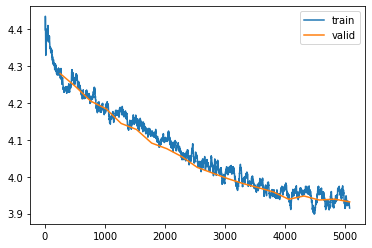

In [37]:
learn.recorder.plot_loss()

## Show model results

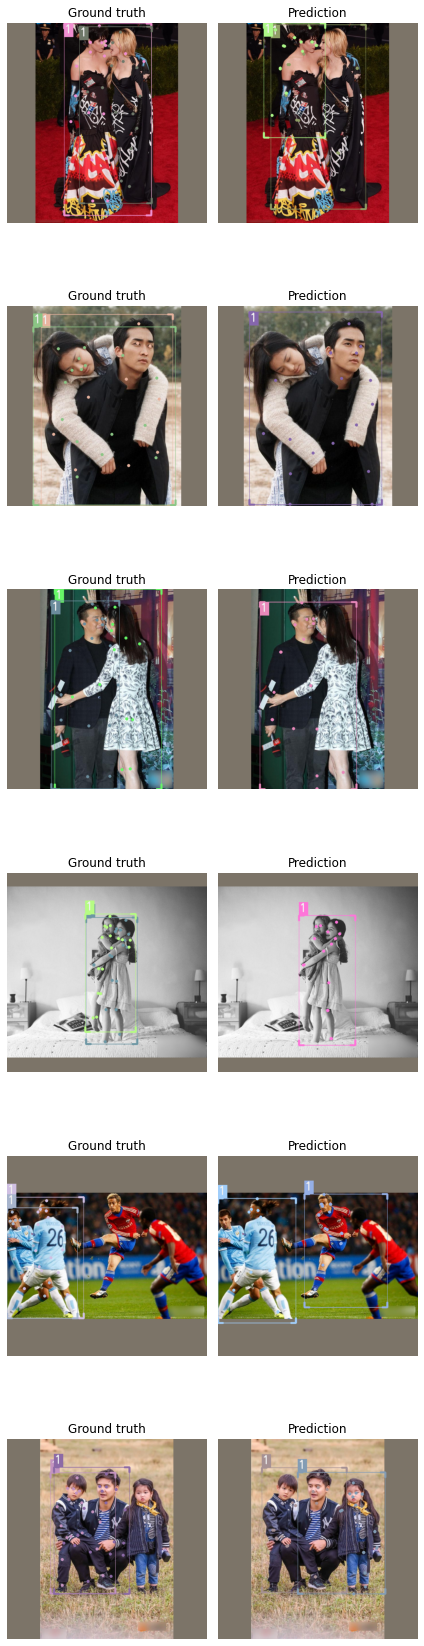

In [32]:
keypoint_rcnn.show_results(model, valid_ds)

## Save model

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/icevision/OCHuman/model.pth")

In [ ]:
model = keypoint_rcnn.model(num_keypoints=19)
state_dict = torch.load("/content/gdrive/My Drive/icevision/OCHuman/model.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Running inference on validation set

In [33]:
infer_dl = keypoint_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = keypoint_rcnn.predict_from_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/128 [00:00<?, ?it/s]

In [35]:
preds[1]

{'labels': array([1, 1]),
 'scores': array([0.9954145 , 0.87553155], dtype=float32),
 'bboxes': [<BBox (xmin:135.16175842285156, ymin:90.47511291503906, xmax:388.1414794921875, ymax:455.3265380859375)>,
  <BBox (xmin:239.25103759765625, ymin:62.99104309082031, xmax:374.84564208984375, ymax:493.66461181640625)>],
 'above_threshold': tensor([ True,  True, False], device='cuda:0'),
 'keypoints': [<KeyPoints (19 visible keypoints)>,
  <KeyPoints (19 visible keypoints)>],
 'keypoints_scores': array([[4.7273316, 4.433237 , 2.8647   , 4.096078 , 3.5330942, 3.1904428,
         2.2852895, 1.2644477, 1.880893 , 2.0137696, 0.9186574, 1.7884026,
         9.4684725, 7.821962 , 8.573485 , 9.469735 , 7.5895596, 8.652597 ,
         8.642918 ],
        [5.2349987, 4.315785 , 2.9298844, 4.9465637, 3.5089214, 3.051835 ,
         3.27213  , 2.6559322, 2.7692387, 4.543542 , 2.9491417, 2.4100673,
         7.3162084, 5.801812 , 7.8256035, 8.6648445, 6.7377696, 8.427677 ,
         7.8614326]], dtype=float32)}

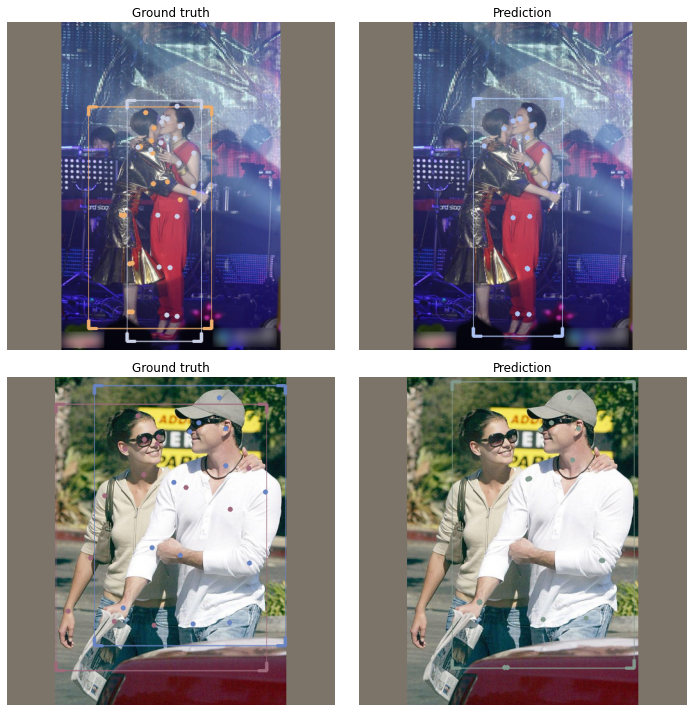

In [36]:
show_preds(samples=samples[68:70], preds=preds[68:70], show=True, display_label=False, figsize=(10, 10))

## `plot_top_losses`

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'loss_keypoint'] | icevision.models.interpretation:plot_top_losses:206


  0%|          | 0/1017 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

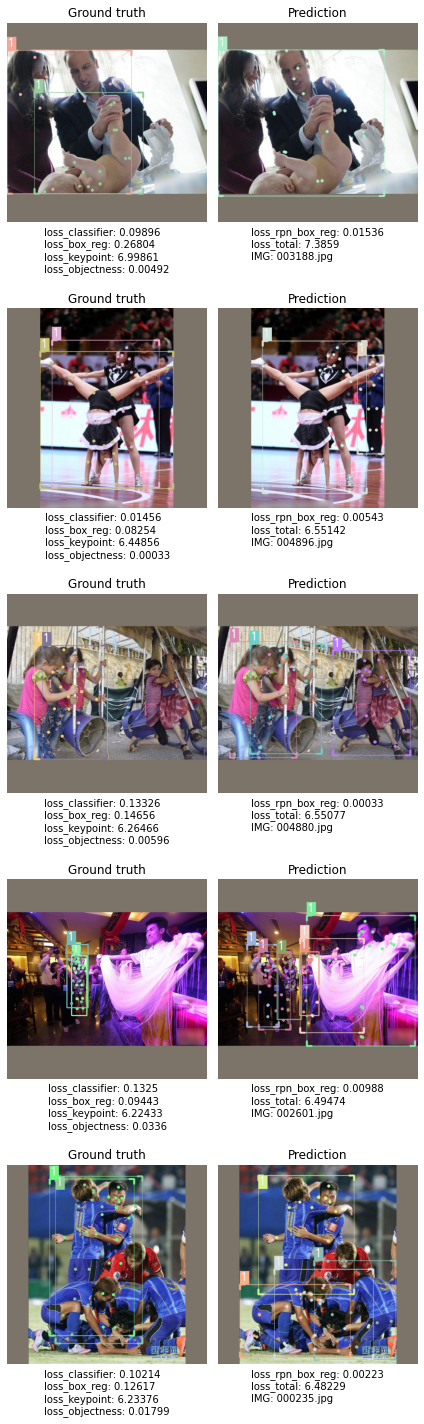

In [57]:
model.train()
sorted_samples, sorted_preds, losses_stats = keypoint_rcnn.interp.plot_top_losses(model, valid_ds, 
                                                                                  sort_by="loss_total")